In [2]:
import os 
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import plotly.io as pio

from scipy.ndimage import gaussian_filter1d
from cmcrameri import cm
from glob import glob
from datetime import datetime
from pandas import concat, DataFrame, read_csv
from numpy import arange, array, linspace
from IPython.display import HTML

import functions as ft

sns.set_style('white')

# Introduction

ToDo
- describe workflow
- 0 replace by average of the surrounding; start from bottom to top indicate estimate as True (additional parameter) - to be saved
- map-batchID vs geo coordinates as JSON

# User Input

In [3]:
user_input_address = "Depot Boijmans Van Beuningen"

# Settings

In [4]:
base_url = 'https://service.pdok.nl'
ENDPOINT_MUNICIPALITY = '/cbs/gebiedsindelingen/2025/wfs/v1_0?request=GetFeature&service=WFS&version=2.0.0&typeName=gemeente_gegeneraliseerd&outputFormat=json'

In [5]:
url_openstreetmap = "https://nominatim.openstreetmap.org/search"

In [6]:
dir_geotop = 'input/GeoTOP_v01r6s1_csv_bestanden/'
dir_export = 'output/'
dir_surface = 'input/maaiveld_dtm/'

In [7]:
save = False

In [8]:
# projections for different coordinate systems
projection_rd_amersfoort = 'epsg:28992'
projection_geocoordinates = 'epsg:4326'

In [9]:
map_lithoclasses = dict({
    0: 'NaN', 1: 'veen', 2: 'klei', 3: 'kleiig_zand', 
    4: 'vervallen', 5: 'zand_fijn', 6: 'zand_matig_grof',
    7: 'zand_grof', 8: 'grind', 9: 'schelpen'
    })

In [10]:
material_color_mapping = dict({
    'NaN': '#ffffff',
    'veen': '#64564c',
    'klei':'#b2a38d', 
    'kleiig_zand':'#8a8783', 
    'vervallen':'#ee82ee', 
    'zand_fijn':'#000000', 
    'zand_matig_grof': '#c5c5c5',  
    'zand_grof': '#616160',
    'grind': '#ffff82',
    'schelpen': '#eb611e' 
    })


In [11]:
data = DataFrame()

In [12]:
axes_color = '#333333'
fontsize = 10

# Get coordinates from User Input

In [13]:
if not user_input_address:
    latitude, longitude = 51.9139529, 4.4711320
    print(f"No user input defined; fall back to default: {latitude}, {longitude} (lat, lon)")

else:
    try:
        geo = requests.get(
            url_openstreetmap, 
            headers={"User-Agent": "CaraLogic (contact: silvia@caralogic.com)"}, 
            params={"q": user_input_address, "format": "json", "limit": 1}
            )

        geo.raise_for_status()
        if len(geo.json()) == 0:
            print(f"no data found for {user_input_address}")
            latitude, longitude = None, None
        else:  
            location = geo.json()[0]
            latitude, longitude = float(location['lat']), float(location['lon']) 
    except:
        latitude, longitude = 51.9139529, 4.4711320

    print(f"Coordinates found for {user_input_address}: {latitude}, {longitude} (lat, lon)")

Coordinates found for Depot Boijmans Van Beuningen: 51.9138029, 4.4712212 (lat, lon)


# Get and Prepare Data

### Get GeoTop Data

In [14]:
ls_files = sorted([file for file in glob(dir_geotop + '*.csv')])
ls_files

['input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B01.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B02.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B03.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B04.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B05.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B06.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B07.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B08.csv',
 'input/GeoTOP_v01r6s1_csv_bestanden/zuidholland_B09.csv']

In [15]:
ls_data = [read_csv(file, index_col=[0,1,2], engine="pyarrow") for file in ls_files]

data = concat(ls_data).sort_index()
data.tail(10).to_clipboard()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24874929 entries, (np.float64(58550.0), np.float64(437550.0), np.float64(-49.75)) to (np.float64(119950.0), np.float64(474950.0), np.float64(-1.25))
Data columns (total 13 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   lithostrat                    int64  
 1   lithoklasse                   int64  
 2   kans_1_veen                   float64
 3   kans_2_klei                   float64
 4   kans_3_kleiig_zand            float64
 5   kans_4_vervallen              float64
 6   kans_5_zand_fijn              float64
 7   kans_6_zand_matig_grof        float64
 8   kans_7_zand_grof              float64
 9   kans_8_grind                  float64
 10  kans_9_schelpen               float64
 11  modelonzekerheid_lithoklasse  float64
 12  modelonzekerheid_lithostrat   float64
dtypes: float64(11), int64(2)
memory usage: 2.5 GB


## Focus on City of Rotterdam

#### Get Rotterdam City Boundary 

In [17]:
municipalities = gpd.read_file(base_url + ENDPOINT_MUNICIPALITY)
municipalities.head()

,statcode,jrstatcode,statnaam,rubriek,id,geometry
0,GM0014,2025GM0014,Groningen,gemeente,1,"MULTIPOLYGON (((245269.7 592530.869, 245344.71..."
1,GM0034,2025GM0034,Almere,gemeente,2,"MULTIPOLYGON (((146891.056 493291.709, 147422...."
2,GM0037,2025GM0037,Stadskanaal,gemeente,3,"MULTIPOLYGON (((263763.866 566430.392, 263988...."
3,GM0047,2025GM0047,Veendam,gemeente,4,"MULTIPOLYGON (((256231.909 572319.213, 258595...."
4,GM0050,2025GM0050,Zeewolde,gemeente,5,"MULTIPOLYGON (((164905.825 488530.789, 165218...."


In [18]:
rotterdam = municipalities[municipalities["statnaam"] == "Rotterdam"]

rotterdam_rd = rotterdam.to_crs(epsg=projection_rd_amersfoort.split('epsg:')[1])
rotterdam_rd_json = json.loads(rotterdam_rd.to_json())

rotterdam_geo = rotterdam.to_crs(epsg=projection_geocoordinates.split('epsg:')[1])
rotterdam_geo_json = json.loads(rotterdam_geo.to_json())

In [19]:
rotterdam_rd_border = DataFrame(rotterdam_rd_json['features'][0]['geometry']['coordinates'][0][0], columns=['x', 'y'])
rotterdam_rd_border

,x,y
0,70083.9840,445080.5930
1,69940.7423,444802.1262
2,70009.7580,444769.3940
3,69819.5960,444392.3730
4,70367.3151,444183.4945
...,...,...
406,68730.7140,446167.7340
407,68821.9000,445974.8370
408,69036.6280,445664.3240
409,69243.8148,445543.2807


#### Crop To Rotterdam City

In [20]:
gdf_points = gpd.GeoDataFrame(
    data, 
    geometry=gpd.points_from_xy(data.reset_index().x, data.reset_index().y), 
    crs=projection_rd_amersfoort
)

In [21]:
points_in_rotterdam = gdf_points[gdf_points.geometry.within(rotterdam_rd.union_all())]
points_in_rotterdam.head()

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
x       y        z                                                           
58550.0 437550.0 -49.75        5120            6         0.00         0.17   
                 -49.25        5120            6         0.00         0.24   
                 -48.75        5120            6         0.02         0.17   
                 -48.25        5120            6         0.04         0.24   
                 -47.75        5120            1         0.06         0.21   

                         kans_3_kleiig_zand  kans_4_vervallen  \
x       y        z                                              
58550.0 437550.0 -49.75                0.23               0.0   
                 -49.25                0.26               0.0   
                 -48.75                0.31               0.0   
                 -48.25                0.32               0.0   
                 -47.75                0.33               0.0   

                         kans_5_zand_fijn  kans_6_zand_matig_grof  \
x       y        z                                                  
58550.0 437550.0 -49.75              0.24                    0.28   
                 -49.25              0.18                    0.24   
                 -48.75              0.18                    0.25   
                 -48.25              0.15                    0.19   
                 -47.75              0.05                    0.27   

                         kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
x       y        z                                                         
58550.0 437550.0 -49.75              0.08           0.0              0.0   
                 -49.25              0.08           0.0              0.0   
                 -48.75              0.07           0.0              0.0   
                 -48.25              0.06           0.0              0.0   
                 -47.75              0.08           0.0              0.0   

                         modelonzekerheid_lithoklasse  \
x       y        z                                      
58550.0 437550.0 -49.75                          0.86   
                 -49.25                          0.86   
                 -48.75                          0.88   
                 -48.25                          0.90   
                 -47.75                          0.87   

                         modelonzekerheid_lithostrat              geometry  
x       y        z                                                          
58550.0 437550.0 -49.75                         0.37  POINT (58550 437550)  
                 -49.25                         0.42  POINT (58550 437550)  
                 -48.75                         0.47  POINT (58550 437550)  
                 -48.25                         0.50  POINT (58550 437550)  
                 -47.75                         0.53  POINT (58550 437550)

In [22]:
print(f"Data points available within Rotterdam {points_in_rotterdam.shape}")

Data points available within Rotterdam (2641848, 14)


## Convert RD-Coordinates to Geo-Coordinates 

and plot in 2D plotly

In [23]:
points_in_rotterdam = ft.convert_rd_into_geocoordinates(points_in_rotterdam)
points_in_rotterdam

lithostrat  lithoklasse  kans_1_veen  kans_2_klei  \
lon      lat       z                                                           
3.985201 51.918065 -49.75        5120            6         0.00         0.17   
                   -49.25        5120            6         0.00         0.24   
                   -48.75        5120            6         0.02         0.17   
                   -48.25        5120            6         0.04         0.24   
                   -47.75        5120            1         0.06         0.21   
...                               ...          ...          ...          ...   
4.600603 51.972333 -5.75         1090            1         0.95         0.05   
                   -5.25         1090            1         0.96         0.04   
                   -4.75         1090            1         0.97         0.03   
                   -4.25         1090            1         0.95         0.05   
                   -3.75         1000            0         0.00         0.00   

                           kans_3_kleiig_zand  kans_4_vervallen  \
lon      lat       z                                              
3.985201 51.918065 -49.75                0.23               0.0   
                   -49.25                0.26               0.0   
                   -48.75                0.31               0.0   
                   -48.25                0.32               0.0   
                   -47.75                0.33               0.0   
...                                       ...               ...   
4.600603 51.972333 -5.75                 0.00               0.0   
                   -5.25                 0.00               0.0   
                   -4.75                 0.00               0.0   
                   -4.25                 0.00               0.0   
                   -3.75                 0.00               0.0   

                           kans_5_zand_fijn  kans_6_zand_matig_grof  \
lon      lat       z                                                  
3.985201 51.918065 -49.75              0.24                    0.28   
                   -49.25              0.18                    0.24   
                   -48.75              0.18                    0.25   
                   -48.25              0.15                    0.19   
                   -47.75              0.05                    0.27   
...                                     ...                     ...   
4.600603 51.972333 -5.75               0.00                    0.00   
                   -5.25               0.00                    0.00   
                   -4.75               0.00                    0.00   
                   -4.25               0.00                    0.00   
                   -3.75               0.00                    0.00   

                           kans_7_zand_grof  kans_8_grind  kans_9_schelpen  \
lon      lat       z                                                         
3.985201 51.918065 -49.75              0.08           0.0              0.0   
                   -49.25              0.08           0.0              0.0   
                   -48.75              0.07           0.0              0.0   
                   -48.25              0.06           0.0              0.0   
                   -47.75              0.08           0.0              0.0   
...                                     ...           ...              ...   
4.600603 51.972333 -5.75               0.00           0.0              0.0   
                   -5.25               0.00           0.0              0.0   
                   -4.75               0.00           0.0              0.0   
                   -4.25               0.00           0.0              0.0   
                   -3.75               0.00           0.0              0.0   

                           modelonzekerheid_lithoklasse  \
lon      lat       z                                      
3.985201 51.918065 -49.75                          0.86  

In [24]:
unique_pairs = points_in_rotterdam.reset_index()[['lat', 'lon']].drop_duplicates()
df_unique_pairs = points_in_rotterdam.reset_index().loc[unique_pairs.index]
df_unique_pairs.head()

,lon,lat,z,lithostrat,lithoklasse,kans_1_veen,kans_2_klei,kans_3_kleiig_zand,kans_4_vervallen,kans_5_zand_fijn,kans_6_zand_matig_grof,kans_7_zand_grof,kans_8_grind,kans_9_schelpen,modelonzekerheid_lithoklasse,modelonzekerheid_lithostrat,geometry
0,3.985201,51.918065,-49.75,5120,6,0.00,0.17,0.23,0.0,0.24,0.28,0.08,0.0,0.0,0.86,0.37,POINT (58550 437550)
98,3.985173,51.918963,-49.75,5120,6,0.01,0.16,0.23,0.0,0.25,0.31,0.04,0.0,0.0,0.85,0.30,POINT (58550 437650)
197,3.985145,51.919862,-49.75,5120,6,0.02,0.19,0.29,0.0,0.20,0.26,0.04,0.0,0.0,0.87,0.37,POINT (58550 437750)
297,3.985117,51.920760,-49.75,5120,6,0.02,0.17,0.31,0.0,0.20,0.27,0.03,0.0,0.0,0.85,0.36,POINT (58550 437850)
397,3.986655,51.918082,-49.75,5120,6,0.00,0.20,0.20,0.0,0.26,0.28,0.06,0.0,0.0,0.85,0.27,POINT (58650 437550)


In [25]:
center_lat, center_lon = unique_pairs.median()

fig = px.scatter_map(
    df_unique_pairs,
    lat="lat", lon="lon", center={"lat": center_lat, "lon": center_lon},
    zoom=9, height=600, map_style="carto-positron"
    )

for feature in rotterdam_geo_json["features"]:
    fig.add_trace(go.Scattermapbox(
        lat=[
            coord[1] for polygon in feature["geometry"]["coordinates"] 
            for coord in (polygon[0] if feature["geometry"]["type"] == "MultiPolygon" else polygon)
            ],
        lon=[
            coord[0] for polygon in feature["geometry"]["coordinates"] 
            for coord in (polygon[0] if feature["geometry"]["type"] == "MultiPolygon" else polygon)
            ],
        mode="lines",
        line=dict(color="red", width=3),
        name="Rotterdam boundary"
    ))

fig.show()

if save:
    print('exporting figure rotterdam_datapoints.html... ')
    pio.write_html(fig, "output/rotterdam_datapoints.html", full_html=True, include_plotlyjs='cdn')


/var/folders/lx/z70mzvpx4ls9np3hfbhll4wr0000gn/T/ipykernel_39275/2298055826.py:10: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# Find Data Points in Data Set from Input

### Get Box Around Address 

In [26]:
print(f"finding closest point to {longitude}, {latitude}:\n")
points_around_input = ft.find_closest_points_to_input(
    data=points_in_rotterdam, latitude=latitude, longitude=longitude, delta_lat=0.002, delta_lon=0.004
    )

finding closest point to 4.4712212, 51.9138029:

found 30 unique lat/lon pairs:
               lat       lon
1891133  51.912045  4.467944
1891233  51.912944  4.467925
1891333  51.913843  4.467907
1891432  51.914741  4.467889
1891530  51.915640  4.467870
1903472  51.912057  4.469397
1903570  51.912955  4.469378
1903668  51.913854  4.469360
1903766  51.914753  4.469342
1903864  51.915651  4.469323
1915953  51.912068  4.470850
1916051  51.912967  4.470832
1916149  51.913865  4.470813
1916247  51.914764  4.470795
1916344  51.915663  4.470777
1928436  51.912079  4.472303
1928534  51.912978  4.472285
1928632  51.913877  4.472267
1928730  51.914775  4.472248
1928828  51.915674  4.472230
1940915  51.912091  4.473756
1941012  51.912989  4.473738
1941109  51.913888  4.473720
1941207  51.914787  4.473702
1941305  51.915685  4.473683
1953364  51.912102  4.475210
1953461  51.913001  4.475191
1953560  51.913899  4.475173
1953657  51.914798  4.475155
1953755  51.915697  4.475137


In [27]:
fig = px.scatter_map(points_around_input[['lat', 'lon']].drop_duplicates(), lat='lat', lon='lon', zoom=15, height=600)
fig.update_traces(marker=dict(size=10))
fig.update_layout(map_style="carto-positron")

fig.add_trace(
    go.Scattermap(
        lat=[latitude],
        lon=[longitude],
        mode="markers",
        marker=dict(
            size=16,
            color="orange",
            symbol="star" 
        ),
        name="User Input {latitude}, {longitude}".format(latitude=latitude, longitude=longitude)
    )
)

HTML(fig.to_html(include_plotlyjs='cdn'))

### Get Profiles for Data Points

In [ ]:
points_around_input['lithoklasse_material'] = [map_lithoclasses[k] for k in points_around_input.lithoklasse]
points_around_input['lithoklasse_color'] = [material_color_mapping[c] 
                                            for c in points_around_input['lithoklasse_material']]

In [ ]:
profiles, unique_points = ft.get_unique_points(points_around_input)

# Separate Data Exploration

### Class Distribution within Rotterdam

In [ ]:
points_in_rotterdam.head()

In [ ]:
lithoclass_overview = concat([
    points_in_rotterdam.lithoklasse.value_counts(),
    points_in_rotterdam.lithoklasse.value_counts(normalize=True)*100], axis=1)

lithoclass_overview

In [ ]:
depth_dist = DataFrame(
    points_in_rotterdam
    .groupby(level='z')['lithoklasse']
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)
depth_dist

### Visualizing Distribution

In [ ]:
df_plot = depth_dist.sort_index()
colors = cm.vik(linspace(0, 1, len(df_plot.columns)))

In [ ]:
fig, ax = plt.subplots(figsize=(5, 7))
df_plot.plot.area(ax=ax, cmap=cm.vik)

plt.gca().invert_xaxis() 
leg = ax.legend(
    title="Lithoklasse", loc='upper left', ncols=8,
    edgecolor=axes_color, borderpad=.65, fontsize=fontsize*0.75
    )
leg.get_frame().set_linewidth(.5)
    
for spine in ax.spines.values():
    spine.set_visible(False)

ax.axhline(y=ax.get_ylim()[0], color=axes_color, linewidth=1.2, zorder=10)
ax.axvline(x=ax.get_xlim()[0], color=axes_color, linewidth=1.2, zorder=10)

ax.tick_params(axis='x', colors=axes_color)
ax.tick_params(axis='y', colors=axes_color)

ax.grid(False)
ax.set_xlabel("Depth $z$, m", fontsize=fontsize)
ax.set_ylabel("Percentage, %", fontsize=fontsize)
ax.set_title("Vertical Distribution of Lithology Classes", loc='left', fontsize=fontsize*1.25)

plt.tight_layout()

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))
for i, col in enumerate(df_plot.columns):
    sns.kdeplot(y=df_plot.index, weights=df_plot[col], bw_adjust=.2, lw=1.5, label=col, ax=ax, color=colors[i])

leg = ax.legend(
    title="Lithoklasse", loc=0, ncols=8,
    edgecolor=axes_color, borderpad=.65, fontsize=fontsize*0.75
    )
leg.get_frame().set_linewidth(.5)
    
for spine in ax.spines.values():
    spine.set_visible(False)

ax.axhline(y=ax.get_ylim()[0], color=axes_color, linewidth=1.2, zorder=10)
ax.axvline(x=ax.get_xlim()[0], color=axes_color, linewidth=1.2, zorder=10)

ax.tick_params(axis='x', colors=axes_color)
ax.tick_params(axis='y', colors=axes_color)

ax.grid(False)
ax.set_ylabel("Depth $z$, m", fontsize=fontsize)
ax.set_xlabel("Percentage, %", fontsize=fontsize)
ax.set_title("Distribution of Lithology Classes", loc='left', fontsize=fontsize*1.25)

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_plot, cmap=cm.batlowW_r, cbar=True, cbar_kws={'label': 'Percentage, %'}, ax=ax)

plt.gca().invert_yaxis() 
plt.xticks(ticks=arange(len(df_plot.columns)), labels=df_plot.columns)

plt.xlabel("Lithoklasse")
plt.ylabel("Depth $z$, m")
plt.title("Lithology Distribution per Depth", loc='left')
plt.tight_layout()
plt.show()

# Data Vis 3D Projection

## Original Voxel

In [ ]:
fig = ft.plot_voxel(
    unique_points, elev=30, azim=45, 
    layer_label='layers',  dx=0.002, dy=0.002, 
    save_name='output/smoothed_dataset',
    save=False, display_plot=True, figsize=(18,6)
    )

if save:
    print('exporting original voxel...')
    fig.savefig(f"output/original_voxel_around_{longitude}-{latitude}.png")

In [ ]:
dic_original_figs = dict()
for azim in linspace(0, 360, 12):
    dic_original_figs[azim] = ft.plot_voxel(
        unique_points, elev=30, azim=azim,
        save_name='output/original_dataset', 
        layer_label='layers',  dx=0.002, dy=0.002, 
        save=True, display_plot=False, figsize=(18,6)
        )

## Smoothing 

### Gaussian Smoothing
also called moving average along the depth axis

In [ ]:
all_materials = list(set(l['lithoklasse_material'] for pt in unique_points for l in pt['layers']))
material_to_num = {m: i for i, m in enumerate(all_materials)}
num_to_material = {i: m for m, i in material_to_num.items()}

smoothed_points = []

# Kernel size: sigma in Gaussian filter controls smoothness
sigma = 2  # adjust; larger = smoother

for pt in unique_points:
    layers = sorted(pt['layers'], key=lambda l: l['z'])
    z_vals = array([l['z'] for l in layers])
    mat_nums = array([material_to_num[l['lithoklasse_material']] for l in layers])
    
    smoothed_nums = gaussian_filter1d(mat_nums.astype(float), sigma=sigma)
    
    smoothed_materials = [num_to_material[int(round(n))] for n in smoothed_nums]
    
    smoothed_layers = [
        {'z': z, 'lithoklasse_material': mat, 'lithoklasse_color': material_color_mapping[mat]} 
        for z, mat in zip(z_vals, smoothed_materials)
        ]
    
    smoothed_points.append({
        'lat': pt['lat'],
        'lon': pt['lon'],
        'layers_smoothed': smoothed_layers
    })


In [ ]:
fig = ft.plot_voxel(
    smoothed_points, elev=30, azim=45, 
    layer_label='layers_smoothed',  dx=0.002, dy=0.002, 
    save_name='output/smoothed_dataset',
    save=False, display_plot=True, figsize=(18,6)
    )

if save:
    print('exporting Gaussian smoothed voxel...')
    fig.savefig(f"output/20251211_Gauss-smoothed_voxel_around_{longitude}-{latitude}.png")

In [ ]:
dic_smoothed_figs = dict()
for azim in linspace(0, 360, 12):
    dic_smoothed_figs[azim] = ft.plot_voxel(
        smoothed_points, layer_label='layers_smoothed', elev=30, azim=azim, save=True, 
        save_name='output/smoothed_dataset', display_plot=False, dx=0.002, dy=0.002, figsize=(18,6)
        )

### Majority Voting / clustering of adjacent same class layers (chosen)
Group in boxes whenever something changed in lat, lon or lithoclasse, <br>
creating a box_start and box_end
-> z_start - z_end!!

In [28]:
data_grouped = points_in_rotterdam.reset_index()

print(data_grouped.shape)
data_grouped.head()

(2641848, 17)


,lon,lat,z,lithostrat,lithoklasse,kans_1_veen,kans_2_klei,kans_3_kleiig_zand,kans_4_vervallen,kans_5_zand_fijn,kans_6_zand_matig_grof,kans_7_zand_grof,kans_8_grind,kans_9_schelpen,modelonzekerheid_lithoklasse,modelonzekerheid_lithostrat,geometry
0,3.985201,51.918065,-49.75,5120,6,0.00,0.17,0.23,0.0,0.24,0.28,0.08,0.0,0.0,0.86,0.37,POINT (58550 437550)
1,3.985201,51.918065,-49.25,5120,6,0.00,0.24,0.26,0.0,0.18,0.24,0.08,0.0,0.0,0.86,0.42,POINT (58550 437550)
2,3.985201,51.918065,-48.75,5120,6,0.02,0.17,0.31,0.0,0.18,0.25,0.07,0.0,0.0,0.88,0.47,POINT (58550 437550)
3,3.985201,51.918065,-48.25,5120,6,0.04,0.24,0.32,0.0,0.15,0.19,0.06,0.0,0.0,0.90,0.50,POINT (58550 437550)
4,3.985201,51.918065,-47.75,5120,1,0.06,0.21,0.33,0.0,0.05,0.27,0.08,0.0,0.0,0.87,0.53,POINT (58550 437550)


In [29]:
data_grouped['group'] = (
    (data_grouped['lithoklasse'] != data_grouped['lithoklasse'].shift()) |
    (data_grouped['lon'] != data_grouped['lon'].shift()) |
    (data_grouped['lat'] != data_grouped['lat'].shift())
).cumsum()

print(data_grouped.shape)
data_grouped.head()

(2641848, 18)


,lon,lat,z,lithostrat,lithoklasse,kans_1_veen,kans_2_klei,kans_3_kleiig_zand,kans_4_vervallen,kans_5_zand_fijn,kans_6_zand_matig_grof,kans_7_zand_grof,kans_8_grind,kans_9_schelpen,modelonzekerheid_lithoklasse,modelonzekerheid_lithostrat,geometry,group
0,3.985201,51.918065,-49.75,5120,6,0.00,0.17,0.23,0.0,0.24,0.28,0.08,0.0,0.0,0.86,0.37,POINT (58550 437550),1
1,3.985201,51.918065,-49.25,5120,6,0.00,0.24,0.26,0.0,0.18,0.24,0.08,0.0,0.0,0.86,0.42,POINT (58550 437550),1
2,3.985201,51.918065,-48.75,5120,6,0.02,0.17,0.31,0.0,0.18,0.25,0.07,0.0,0.0,0.88,0.47,POINT (58550 437550),1
3,3.985201,51.918065,-48.25,5120,6,0.04,0.24,0.32,0.0,0.15,0.19,0.06,0.0,0.0,0.90,0.50,POINT (58550 437550),1
4,3.985201,51.918065,-47.75,5120,1,0.06,0.21,0.33,0.0,0.05,0.27,0.08,0.0,0.0,0.87,0.53,POINT (58550 437550),2


In [30]:
likelihood_cols = [col for col in data_grouped.columns if col.startswith('kans_')]
likelihood_cols

['kans_1_veen',
 'kans_2_klei',
 'kans_3_kleiig_zand',
 'kans_4_vervallen',
 'kans_5_zand_fijn',
 'kans_6_zand_matig_grof',
 'kans_7_zand_grof',
 'kans_8_grind',
 'kans_9_schelpen']

When grouping, calculate the average for the columns but for lon, lat, z, lothology and likelihood columns, do the following specifically (agg_dict):
- lon / lat → keep single value or list of unique values
- z → min and max
- lithology → take the first value
- likelihood columns → take the mean

In [31]:
agg_dict = {
    'lon': lambda x: x.iloc[0] if x.nunique() == 1 else list(x.unique()),
    'lat': lambda x: x.iloc[0] if x.nunique() == 1 else list(x.unique()),

    'z': ['min', 'max'],

    'lithostrat': lambda x: x.iloc[0],
    'lithoklasse': lambda x: x.iloc[0],
}

In [32]:
for col in likelihood_cols:
    agg_dict[col] = 'mean'

df_grouped = data_grouped.groupby('group').agg(agg_dict)
df_grouped.columns = [
    f'{c[0]}_{c[1]}' if isinstance(c, tuple) else c
    for c in df_grouped.columns
]

In [33]:
df_grouped = df_grouped.rename(columns={
    'lon_<lambda>': 'lon',
    'lat_<lambda>': 'lat',
    'lithoklasse_<lambda>': 'lithoklasse',
    'lithostrat_<lambda>': 'lithostrat',
})

print(df_grouped.shape)
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.head()

(724376, 15)


,lon,lat,z_min,z_max,lithostrat,lithoklasse,kans_1_veen_mean,kans_2_klei_mean,kans_3_kleiig_zand_mean,kans_4_vervallen_mean,kans_5_zand_fijn_mean,kans_6_zand_matig_grof_mean,kans_7_zand_grof_mean,kans_8_grind_mean,kans_9_schelpen_mean
0,3.985201,51.918065,-49.75,-48.25,5120,6,0.015,0.205,0.28,0.0,0.1875,0.240,0.0725,0.0,0.0
1,3.985201,51.918065,-47.75,-47.75,5120,1,0.060,0.210,0.33,0.0,0.0500,0.270,0.0800,0.0,0.0
2,3.985201,51.918065,-47.25,-46.75,5120,6,0.030,0.130,0.19,0.0,0.2600,0.285,0.1050,0.0,0.0
3,3.985201,51.918065,-46.25,-46.25,5120,2,0.020,0.270,0.21,0.0,0.2300,0.180,0.0900,0.0,0.0
4,3.985201,51.918065,-45.75,-45.75,5120,5,0.020,0.250,0.33,0.0,0.1900,0.150,0.0600,0.0,0.0


Verify averaging to add to 100%

In [34]:
data_kans = data_grouped.filter(like='kans_').sum(axis=1)
data_kans

0          1.0
1          1.0
2          1.0
3          1.0
4          1.0
          ... 
2641843    1.0
2641844    1.0
2641845    1.0
2641846    1.0
2641847    0.0
Length: 2641848, dtype: float64

<Axes: >

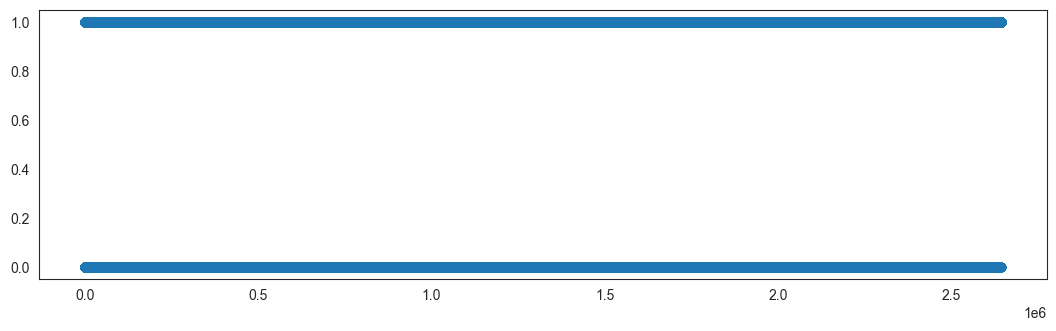

In [35]:
data_kans.plot(lw=0, marker='o', figsize=(13, 3.5))

In [36]:
df_grouped['lithoklasse_material'] = [map_lithoclasses[k] for k in df_grouped.lithoklasse]
df_grouped['lithoklasse_color'] = [material_color_mapping[c] for c in df_grouped['lithoklasse_material']]

In [37]:
filtered = df_grouped[df_grouped['lon'].isin(points_around_input.lon.unique())]
filtered = filtered[filtered['lat'].isin(points_around_input.lat.unique())]
filtered

,lon,lat,z_min,z_max,lithostrat,lithoklasse,kans_1_veen_mean,kans_2_klei_mean,kans_3_kleiig_zand_mean,kans_4_vervallen_mean,kans_5_zand_fijn_mean,kans_6_zand_matig_grof_mean,kans_7_zand_grof_mean,kans_8_grind_mean,kans_9_schelpen_mean,lithoklasse_material,lithoklasse_color
512173,4.467944,51.912045,-49.75,-49.75,5120,3,0.000000,0.140000,0.360000,0.0,0.290000,0.200000,0.010,0.0,0.0,kleiig_zand,#8a8783
512174,4.467944,51.912045,-49.25,-48.75,5120,5,0.000000,0.080000,0.270000,0.0,0.380000,0.265000,0.005,0.0,0.0,zand_fijn,#000000
512175,4.467944,51.912045,-48.25,-48.25,5120,3,0.000000,0.110000,0.390000,0.0,0.250000,0.220000,0.030,0.0,0.0,kleiig_zand,#8a8783
512176,4.467944,51.912045,-47.75,-46.25,5120,5,0.005000,0.102500,0.167500,0.0,0.377500,0.232500,0.115,0.0,0.0,zand_fijn,#000000
512177,4.467944,51.912045,-45.75,-45.75,5120,2,0.010000,0.550000,0.340000,0.0,0.040000,0.040000,0.020,0.0,0.0,klei,#b2a38d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530298,4.475137,51.915697,-15.25,-14.75,2010,2,0.000000,0.540000,0.410000,0.0,0.025000,0.010000,0.015,0.0,0.0,klei,#b2a38d
530299,4.475137,51.915697,-14.25,-14.25,2010,3,0.010000,0.410000,0.380000,0.0,0.120000,0.020000,0.060,0.0,0.0,kleiig_zand,#8a8783
530300,4.475137,51.915697,-13.75,-7.75,1100,2,0.018462,0.895385,0.078462,0.0,0.003077,0.004615,0.000,0.0,0.0,klei,#b2a38d
530301,4.475137,51.915697,-7.25,-4.75,1090,1,0.960000,0.040000,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0,veen,#64564c


In [38]:
profiles_grouped, unique_points_grouped = ft.get_unique_points(points_around_input=filtered)

processed 30 unique lat/lon pairs


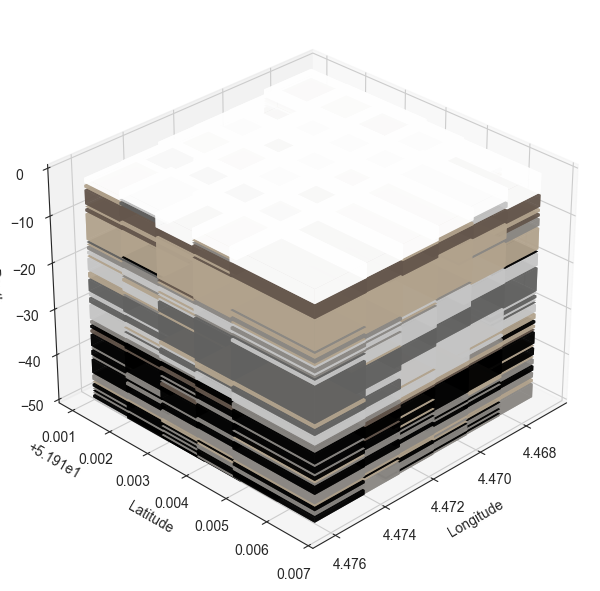

In [39]:
fig = ft.plot_voxel(
    unique_points_grouped, elev=30, azim=45, 
    layer_label='layers',  dx=0.002, dy=0.002, 
    save_name='output/smoothed_dataset',
    save=False, display_plot=True, figsize=(18,6)
    )

if save:
    fig.savefig(f"output/20251211_Content-smoothed_voxel_around_{longitude}-{latitude}.png")

# Get Surface Layer Info per unique Point

In [40]:
unique_pairs_coords_selected = ft.get_surface_layer_of_area(df_unique_pairs, dir_surface)

In [41]:
unique_pairs_coords_selected

,lon,lat,x_rd,y_rd,surface_level_m_NAP
0,3.985201,51.918065,58550.0,437550.0,2.1032
98,3.985173,51.918963,58550.0,437650.0,2.0537
197,3.985145,51.919862,58550.0,437750.0,2.0290
297,3.985117,51.920760,58550.0,437850.0,2.3117
397,3.986655,51.918082,58650.0,437550.0,0.8696
...,...,...,...,...,...
2641393,4.597392,51.989389,100750.0,444850.0,NaN
2641486,4.599163,51.971424,100850.0,442850.0,NaN
2641574,4.599148,51.972323,100850.0,442950.0,NaN
2641662,4.599132,51.973222,100850.0,443050.0,NaN


# Output as JSON

### Prepare for Output

In [42]:
columns_kans = df_grouped.filter(like='kans_').columns
df_grouped[columns_kans] = df_grouped[columns_kans].round(4)

In [43]:
df_grouped.rename(columns={'z_min': 'z_bottom', 'z_max': 'z_top'}, inplace=True)

In [44]:
lithoclass_material = df_grouped['lithoklasse'].map(map_lithoclasses)
df_grouped['lithoclass_material'] = lithoclass_material

In [45]:
selected_columns = [
    'lon', 'lat', 'z_top', 'z_bottom', 'lithoklasse', 'lithoclass_material', 
    'kans_1_veen_mean', 'kans_2_klei_mean', 'kans_3_kleiig_zand_mean', 
    'kans_4_vervallen_mean', 'kans_5_zand_fijn_mean', 'kans_6_zand_matig_grof_mean', 
    'kans_7_zand_grof_mean', 'kans_8_grind_mean', 'kans_9_schelpen_mean'
]

cropped = df_grouped.reset_index()[selected_columns]
cropped.rename(columns={
    'lithoklasse':'lithoklasse_id', 
    'lithoclass_material':'lithoklasse'
    }, inplace=True)

cropped

,lon,lat,z_top,z_bottom,lithoklasse_id,lithoklasse,kans_1_veen_mean,kans_2_klei_mean,kans_3_kleiig_zand_mean,kans_4_vervallen_mean,kans_5_zand_fijn_mean,kans_6_zand_matig_grof_mean,kans_7_zand_grof_mean,kans_8_grind_mean,kans_9_schelpen_mean
0,3.985201,51.918065,-48.25,-49.75,6,zand_matig_grof,0.0150,0.2050,0.2800,0.0,0.1875,0.240,0.0725,0.0,0.0
1,3.985201,51.918065,-47.75,-47.75,1,veen,0.0600,0.2100,0.3300,0.0,0.0500,0.270,0.0800,0.0,0.0
2,3.985201,51.918065,-46.75,-47.25,6,zand_matig_grof,0.0300,0.1300,0.1900,0.0,0.2600,0.285,0.1050,0.0,0.0
3,3.985201,51.918065,-46.25,-46.25,2,klei,0.0200,0.2700,0.2100,0.0,0.2300,0.180,0.0900,0.0,0.0
4,3.985201,51.918065,-45.75,-45.75,5,zand_fijn,0.0200,0.2500,0.3300,0.0,0.1900,0.150,0.0600,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724371,4.600603,51.972333,-11.25,-11.25,2,klei,0.0700,0.8600,0.0700,0.0,0.0000,0.000,0.0000,0.0,0.0
724372,4.600603,51.972333,-10.25,-10.75,1,veen,0.4000,0.3400,0.1100,0.0,0.0800,0.050,0.0200,0.0,0.0
724373,4.600603,51.972333,-9.75,-9.75,2,klei,0.0900,0.6100,0.2000,0.0,0.0400,0.040,0.0200,0.0,0.0
724374,4.600603,51.972333,-4.25,-9.25,1,veen,0.8264,0.1273,0.0464,0.0,0.0000,0.000,0.0000,0.0,0.0


In [47]:
df_merged = cropped.merge(
    unique_pairs_coords_selected[['lat', 'lon', 'surface_level_m_NAP']],
    on=['lat', 'lon'],
    how='left'  
)

df_merged.loc[df_merged['surface_level_m_NAP'].isna(), 'surface_level_m_NAP'] = 0
df_merged

,lon,lat,z_top,z_bottom,lithoklasse_id,lithoklasse,kans_1_veen_mean,kans_2_klei_mean,kans_3_kleiig_zand_mean,kans_4_vervallen_mean,kans_5_zand_fijn_mean,kans_6_zand_matig_grof_mean,kans_7_zand_grof_mean,kans_8_grind_mean,kans_9_schelpen_mean,surface_level_m_NAP
0,3.985201,51.918065,-48.25,-49.75,6,zand_matig_grof,0.0150,0.2050,0.2800,0.0,0.1875,0.240,0.0725,0.0,0.0,2.1032
1,3.985201,51.918065,-47.75,-47.75,1,veen,0.0600,0.2100,0.3300,0.0,0.0500,0.270,0.0800,0.0,0.0,2.1032
2,3.985201,51.918065,-46.75,-47.25,6,zand_matig_grof,0.0300,0.1300,0.1900,0.0,0.2600,0.285,0.1050,0.0,0.0,2.1032
3,3.985201,51.918065,-46.25,-46.25,2,klei,0.0200,0.2700,0.2100,0.0,0.2300,0.180,0.0900,0.0,0.0,2.1032
4,3.985201,51.918065,-45.75,-45.75,5,zand_fijn,0.0200,0.2500,0.3300,0.0,0.1900,0.150,0.0600,0.0,0.0,2.1032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724371,4.600603,51.972333,-11.25,-11.25,2,klei,0.0700,0.8600,0.0700,0.0,0.0000,0.000,0.0000,0.0,0.0,0.0000
724372,4.600603,51.972333,-10.25,-10.75,1,veen,0.4000,0.3400,0.1100,0.0,0.0800,0.050,0.0200,0.0,0.0,0.0000
724373,4.600603,51.972333,-9.75,-9.75,2,klei,0.0900,0.6100,0.2000,0.0,0.0400,0.040,0.0200,0.0,0.0,0.0000
724374,4.600603,51.972333,-4.25,-9.25,1,veen,0.8264,0.1273,0.0464,0.0,0.0000,0.000,0.0000,0.0,0.0,0.0000


In [46]:
profiled = cropped.groupby(['lon', 'lat']).apply(
    lambda g: sorted(g.to_dict(orient='records'), key=lambda d: d['z_top'], reverse=True)
).reset_index(name='data')

list_of_lists = profiled['data'].tolist()

/var/folders/lx/z70mzvpx4ls9np3hfbhll4wr0000gn/T/ipykernel_39275/827594227.py:1: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [60]:
map_coordinates_batch = profiled[['lon', 'lat']]
map_coordinates_batch

,lon,lat
0,3.985117,51.920760
1,3.985145,51.919862
2,3.985173,51.918963
3,3.985201,51.918065
4,3.986542,51.921676
...,...,...
27659,4.597708,51.971414
27660,4.599132,51.973222
27661,4.599148,51.972323
27662,4.599163,51.971424


In [ ]:
lat_search = 51.924303
lon_search = 4.480202

In [ ]:
closest_coordinates = ft.find_closest_points_to_input(
    map_coordinates_batch, lat_search, lon_search, delta_lat=0.001, delta_lon=0.001
    )

### Export all data in one file

for all data points, describe the identified lithoclass (through mapping) and select likelihood of all material being present 

In [ ]:
base_name = f"B01-to-B09_lithoclass_materials_and_likelihood_geocoordinates"
name_file =  f"_Rotterdam_city_{datetime.now().date().isoformat()}.json"
file_path = dir_export + base_name + name_file

with open(file_path, 'w') as f:
    json.dump(list_of_lists, f)

print(f"stored {file_path}")

### Export in batches

In [55]:
MAX_BYTES = 5 * 1024 * 1024  # 5 MB

batch_size = 0
file_index = 1
batch = {}
batch_index = 1
current_size = 0
mapping_rows = []

output_dir = dir_export + f"json_5MB_chunks_{datetime.now().date().isoformat()}/"
os.makedirs(output_dir, exist_ok=True)


layer_cols = [
    "z_top", "z_bottom", "lithoklasse_id", "lithoklasse",
    "kans_1_veen_mean", "kans_2_klei_mean", "kans_3_kleiig_zand_mean",
    "kans_4_vervallen_mean", "kans_5_zand_fijn_mean", "kans_6_zand_matig_grof_mean",
    "kans_7_zand_grof_mean", "kans_8_grind_mean", "kans_9_schelpen_mean"
]

In [57]:
for (lat, lon), group in df_merged.groupby(['lat', 'lon']):
    surface_level = group['surface_level_m_NAP'].iloc[0]
    layers = group[layer_cols].to_dict(orient='records')
    
    key = f"{lat},{lon},{surface_level}"
    batch[key] = layers
    
    mapping_rows.append({
        "lat": lat,
        "lon": lon,
        "surface_level": surface_level,
        "batch_id": batch_index
    })
    
    current_size += len(json.dumps({key: layers}))
    
    if current_size >= MAX_BYTES:
        filename = output_dir + f"litho_batch_{batch_index}.json"
        with open(filename, "w") as f:
            json.dump(batch, f, indent=2)
        print(f"Saved {filename} ({current_size / 1024 / 1024:.2f} MB)")

        batch_index += 1
        batch = {}
        current_size = 0

if batch:
    filename = output_dir + f"litho_batch_{batch_index}.json"
    with open(filename, "w") as f:
        json.dump(batch, f, indent=2)
    print(f"Saved {filename} ({current_size / 1024 / 1024:.2f} MB)")

df_mapping = DataFrame(mapping_rows)
df_mapping.to_csv(output_dir + "batch_index.txt", index=False)
print(f"Mapping table saved as {output_dir}/batch_index.txt")

Saved output/json_5MB_chunks_2026-02-16/litho_batch_50.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_51.json (5.00 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_52.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_53.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_54.json (5.00 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_55.json (5.00 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_56.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_57.json (5.00 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_58.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_59.json (5.00 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_60.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_61.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_62.json (5.01 MB)
Saved output/json_5MB_chunks_2026-02-16/litho_batch_63.json (5.00 MB)
Saved output/json_5M

In [52]:
print(
    f'Total number of data points: {len(list_of_lists)} '
    f'\nAmount of entries in first set: {len(list_of_lists[0])}'
    )

Total number of data points: 27664 
Amount of entries in first set: 19


In [ ]:
profiled['file_index'] = -1  

file_index = 0
for idx, sublist in enumerate(list_of_lists):
    sublist_bytes = len(json.dumps(sublist, separators=(',', ':')).encode('utf-8'))
    if batch_size + sublist_bytes > MAX_BYTES and batch:
        file_name = os.path.join(output_dir, f"litho_batch_{file_index}.json")
        with open(file_name, 'w') as f:
            json.dump(batch, f, separators=(',', ':'))
        print(f"Stored {file_name} ({batch_size / 1024**2:.2f} MB)")
        file_index += 1
        batch = []
        batch_size = 0
    
    batch.append(sublist)
    batch_size += sublist_bytes
    profiled.loc[idx, 'batchID'] = file_index  

if batch:
    file_name = os.path.join(output_dir, f"litho_batch_{file_index}.json")
    with open(file_name, 'w') as f:
        json.dump(batch, f, separators=(',', ':'))
    print(f"Stored {file_name} ({batch_size / 1024**2:.2f} MB)")

## Store map of batch to coordinates

In [ ]:
profiled[['lon', 'lat', 'batchID']].to_csv(output_dir + 'map_coordinates2batch.txt', index_label=False)

In [ ]:
concat([profiled[profiled.lon == lon] for lon in closest_coordinates.lon]).batchID.unique()

# Read JSON

In [ ]:
output_dir = 'output/json_5MB_chunks_2025-12-04/'

In [ ]:
ls_files_for_read = [file for file in glob(output_dir + '*.json')]

In [ ]:
ls_df = []
for en, path in enumerate(ls_files_for_read):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        print(f"Reading file {en+1} from {len(ls_files_for_read)}...")

        dfs = []

        for f_sub in data:
            if isinstance(f_sub, list):
                if len(f_sub) > 0 and isinstance(f_sub[0], dict):
                    dfs.append(DataFrame(f_sub))
                else:
                    dfs.append(DataFrame({"value": f_sub}))
            
            elif isinstance(f_sub, dict):
                dfs.append(DataFrame([f_sub]))

            else:
                dfs.append(DataFrame({"value": [f_sub]}))

        file_df = concat(dfs, ignore_index=True)
        ls_df.append(file_df)


df_import = concat(ls_df)

In [ ]:
print(
    f"comparing shapes of datasets:"
    f"\n original dataset: {cropped.shape},"
    f"\n re-imported dataset: {df_import.shape} and"
    f"\n duplicated removed: {df_import.drop_duplicates().shape}")